In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz

## TODO
- Display percentages
- Sort the categories

In [2]:
df = pd.read_csv('marketing_data.csv')
#Preprocess Income
df['Income']=df[' Income ']
df['Income']=df.Income.str.replace('$','')
df['Income']=df.Income.str.replace(',','')#.astype("Int64")
df['Income']=df.Income.astype("float")
df['Income'].fillna((df['Income'].median()), inplace=True)
df = df.drop([' Income '], axis=1)
df.drop(df.index[[527]],inplace=True)
df['LogIncome'] = np.log1p(df['Income'])

#Preprocess Education
df.loc[df['Education']=='2n Cycle','Education']='Master'
df.loc[df['Education']=='Graduation','Education']='Bachelor'

#Preprocess Children
df['NumChildren']  = df['Kidhome']+df['Teenhome']
df['HasChildren']=np.where(df.NumChildren> 0, 1, 0)

#Preprocess Marital Status
df['Solitary']=np.where(((df.Marital_Status== 'Married')|(df.Marital_Status== 'Together')), 0, 1)

#Preprocess Date and Make Age
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
df['age'] = 2014 - df['Year_Birth']

#Make total spending, num promotions, and num orders accepted columns
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] +\
        +df['MntSweetProducts'] + df['MntGoldProds']
df['AcceptedCmpTot']=df['AcceptedCmp1']+ df['AcceptedCmp2']+ df['AcceptedCmp3']+ df['AcceptedCmp4']+\
       + df['AcceptedCmp5']
df['NumTotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases']+df['NumCatalogPurchases']+\
    df['NumStorePurchases']+df['NumWebVisitsMonth']

# Make a column for spending normalized by length customer -> Consider doing this for other amounts as well
latest_date=(df["Dt_Customer"] + pd.to_timedelta(df['Recency'],'d')).max()
df['Len_Customer']=latest_date - df["Dt_Customer"]
df['Len_Customer']=df['Len_Customer'] / pd.to_timedelta(1, unit='D') #Convert to float
df['MntSpentNorm']=df['MntTotal']/df['Len_Customer']

In [3]:
#### Perhaps consider passing dictionaries manually to a replace method as in https://pbpython.com/categorical-encoding.html

In [4]:
# cats = {'Education', 'Marital_Status', 
#        'Kidhome', 'Teenhome','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
#        'AcceptedCmp2', 'Response', 'Complain','Country','HasChildren','Solitary',}
# for var in cats:
#     df[var] = df[var].astype('category').cat.codes


# nums = (set(df.columns) -set(cats)) - {'ID','Dt_Customer'}

# X = df.drop(['Dt_Customer','ID'],axis=1) #Dropping Dt_Customer since this is causing problems in RF

In [4]:
cats = {'Education', 'Marital_Status', 
       'Kidhome', 'Teenhome','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Response', 'Complain','Country','HasChildren','Solitary',}
# for var in cats:
#     df[var] = df[var].astype('category').cat.codes

#still have Len_Customer
nums = (set(df.columns) -set(cats)) - {'ID','Dt_Customer','LogIncome','MntSpentNorm','MntTotal','AcceptedCmpTot','NumTotalPurchases','age','NumChildren'} #drop some highly correlated transformed vars

#X = df.drop(list(nums),axis=1) #Dropping Dt_Customer since this is causing problems in RF
X = df[list(nums)] #Dropping Dt_Customer since this is causing problems in RF

In [32]:
pd.set_option('display.max_columns', 500)

In [33]:
X.head()

,MntMeatProducts,MntSweetProducts,NumWebVisitsMonth,MntWines,NumCatalogPurchases,Len_Customer,Year_Birth,MntGoldProds,NumStorePurchases,Income,NumDealsPurchases,NumWebPurchases,MntFishProducts,Recency,MntFruits
0,379,189,1,189,4,110.0,1970,218,6,84835.0,1,4,111,0,104
1,64,0,5,464,3,111.0,1961,37,7,57091.0,1,7,7,0,5
2,59,2,2,134,2,144.0,1958,30,5,67267.0,1,3,15,0,11
3,1,0,7,10,0,146.0,1967,0,2,32474.0,1,1,0,0,0
4,24,0,7,6,1,179.0,1989,34,2,21474.0,2,3,11,0,16


In [34]:
np.shape(X)

(2239, 15)

In [35]:
num_features = np.shape(X)[1]

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

In [37]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 0.95)
# pca.fit(data_rescaled)
# reduced = pca.transform(data_rescaled)

# print(np.shape(reduced))

# columns = ['col'+str(i) for i in range(1,20)]

# pca = PCA(n_components=19)
# pca.fit(X)
# PCA_ds = pd.DataFrame(pca.transform(X), columns=(columns))
# PCA_ds.describe().T

Elbow Method:


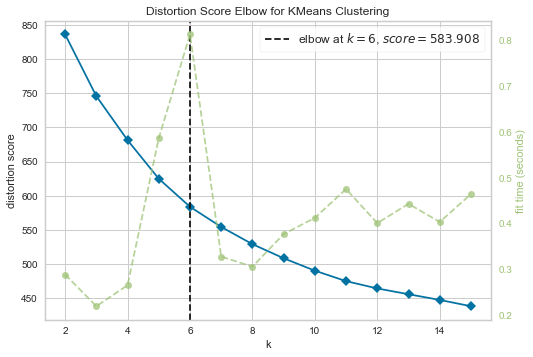

In [38]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method:')
Elbow_M = KElbowVisualizer(KMeans(), k=num_features) #for the 20 numeric
Elbow_M.fit(data_rescaled) 
Elbow_M.show();

In [39]:
n_clusters=7

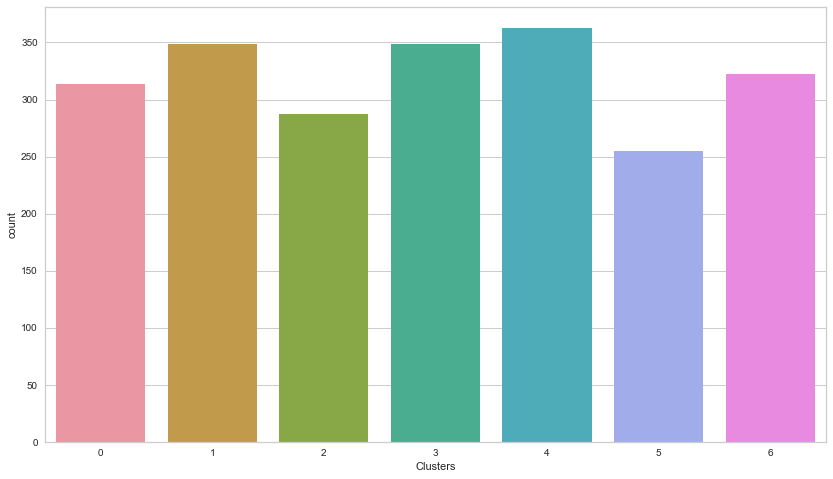

In [40]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Clusters'] = kmeans.fit_predict(data_rescaled)

plt.figure(figsize=(14, 8))
sns.countplot(x='Clusters', data=df)
plt.show()

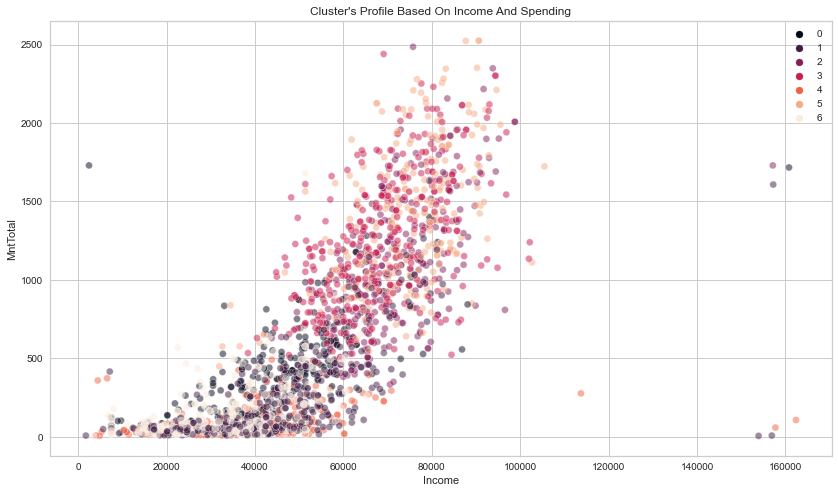

In [41]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntTotal"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

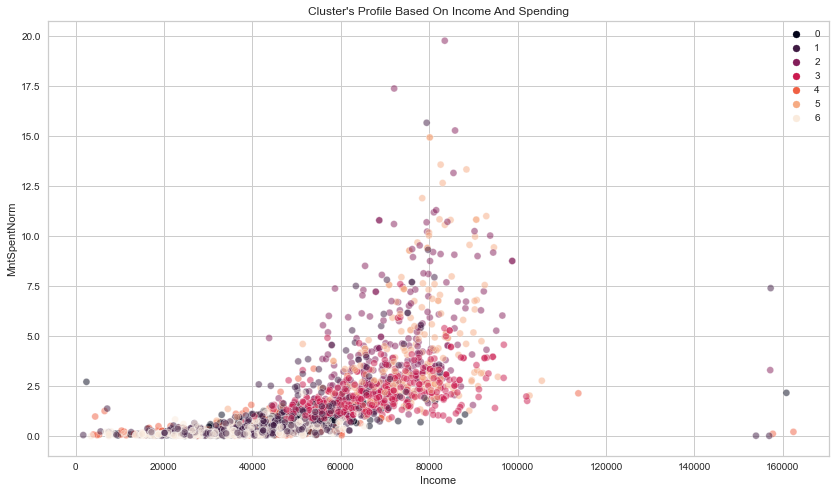

In [42]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntSpentNorm"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [43]:
df["Clusters"].value_counts()

4    363
3    349
1    349
6    322
0    314
2    287
5    255
Name: Clusters, dtype: int64

In [44]:
groupsKmeans=df.groupby(['Clusters'])#.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

In [45]:
groupsKmeans.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

ID                                               Year_Birth  \
         count      sum min    max         mean          std      count   
Clusters                                                                  
0          314  1757321  25  11187  5596.563694  3326.277462        314   
1          349  1874129  20  11188  5369.997135  3089.096881        349   
2          287  1764951   1  11176  6149.655052  3162.229967        287   
3          349  1846271  17  11088  5290.174785  3241.653298        349   
4          363  2058666  49  11191  5671.256198  3312.436301        363   
5          255  1416778   0  11112  5555.992157  3248.748909        255   
6          322  1798890   9  11166  5586.614907  3298.180023        322   

                                                     Kidhome               \
             sum   min   max         mean        std   count  sum min max   
Clusters                                                                    
0         618391  1946  1996  1969.398089  11.312754     314  188   0   2   
1         686758  1900  1996  1967.787966  11.713082     349  210   0   2   
2         564166  1943  1995  1965.735192  12.438924     287   23   0   2   
3         686297  1941  1995  1966.467049  11.832265     349   36   0   2   
4         715654  1893  1992  1971.498623  11.209057     363  277   0   2   
5         502198  1899  1994  1969.403922  13.167814     255   14   0   1   
6         634684  1946  1992  1971.068323  11.402642     322  246   0   2   

                             Teenhome                                   \
              mean       std    count  sum min max      mean       std   
Clusters                                                                 
0         0.598726  0.516314      314  194   0   2  0.617834  0.536645   
1         0.601719  0.561297      349  219   0   2  0.627507  0.571286   
2         0.080139  0.284548      287  140   0   2  0.487805  0.541002   
3         0.103152  0.313886      349  197   0   2  0.564470  0.546145   
4         0.763085  0.513963      363  171   0   2  0.471074  0.526760   
5         0.054902  0.228237      255   64   0   2  0.250980  0.460816   
6         0.763975  0.517790      322  149   0   2  0.462733  0.529659   

         Recency                                      MntWines               \
           count    sum min max       mean        std    count     sum  min   
Clusters                                                                      
0            314   7571   0  64  24.111465  15.462528      314   55542    0   
1            349  26724  45  99  76.573066  14.722274      349   43290    0   
2            287   8721   0  93  30.386760  21.716391      287  164303    1   
3            349  23292   2  99  66.739255  22.350221      349  251434  121   
4            363   8729   0  53  24.046832  15.116144      363   16698    0   
5            255  11702   0  99  45.890196  26.976581      255  127592   33   
6            322  23243  37  99  72.183230  15.815150      322   21948    0   

                                       MntFruits                              \
           max        mean         std     count    sum min  max        mean   
Clusters                                                                       
0         1099  176.885350  192.162304       314   3416   0  103   10.878981   
1          934  124.040115  162.674181       349   2724   0  127    7.805158   
2         1478  572.484321  306.485250       287   9351   0  174   32.581882   
3         1493  720.441261  312.953239       349  13415   0  159   38.438395   
4          408   46.000000   68.808486       363   1428   0   58    3.933884   
5         1259  500.360784  258.277431       255  26625   0  199  104.411765   
6          691   68.161491  107.662036       322   1944   0   65    6.037267   

                    MntMeatProducts                                            \
                std           count     sum min   max        mean         st

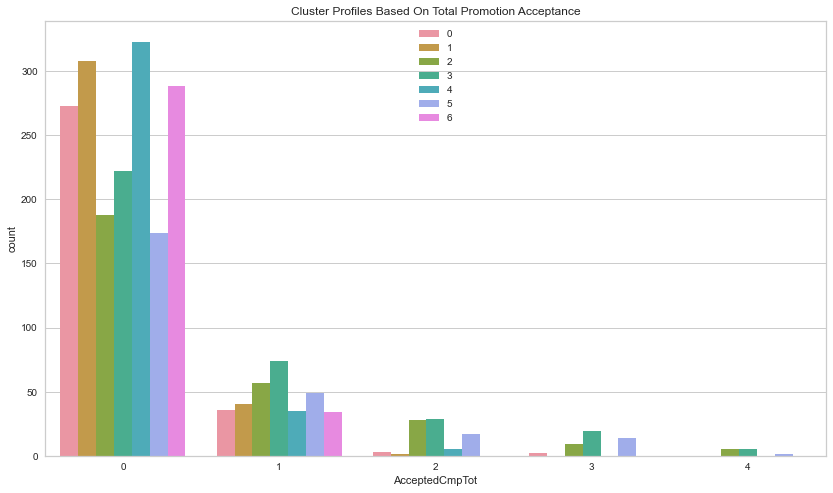

In [46]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmpTot"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Total Promotion Acceptance")
plt.legend()
plt.show()

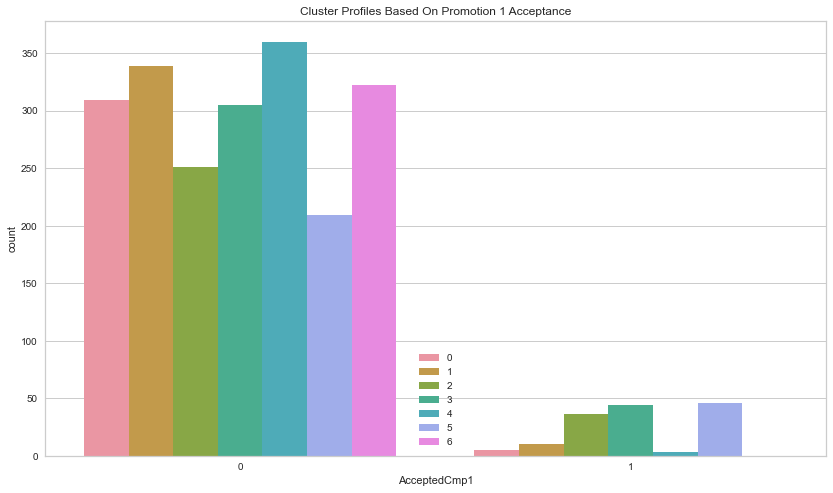

In [47]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp1"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 1 Acceptance")
plt.legend()
plt.show()

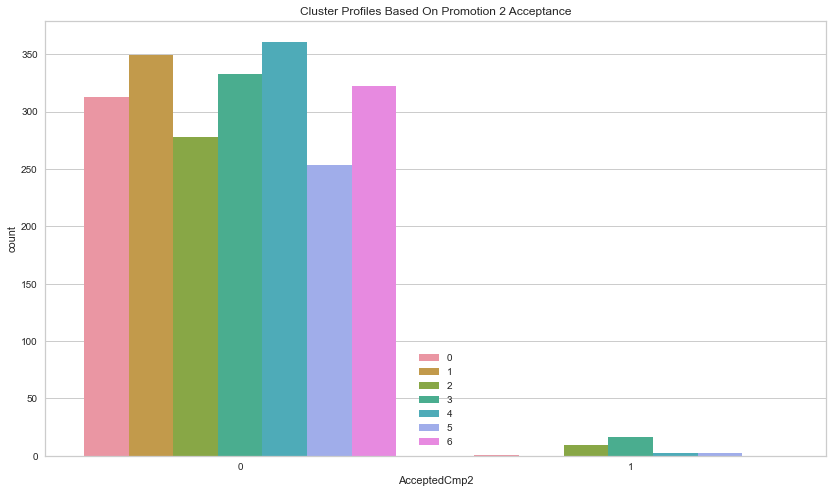

In [48]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp2"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 2 Acceptance")
plt.legend()
plt.show()

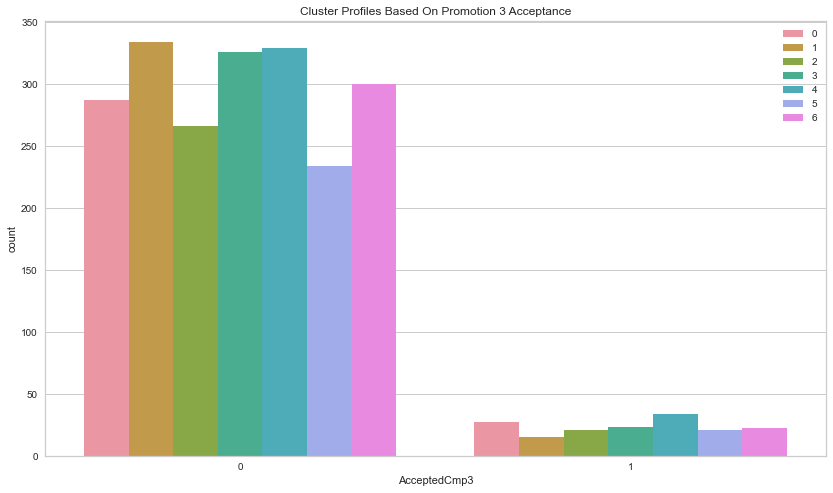

In [49]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp3"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 3 Acceptance")
plt.legend()
plt.show()

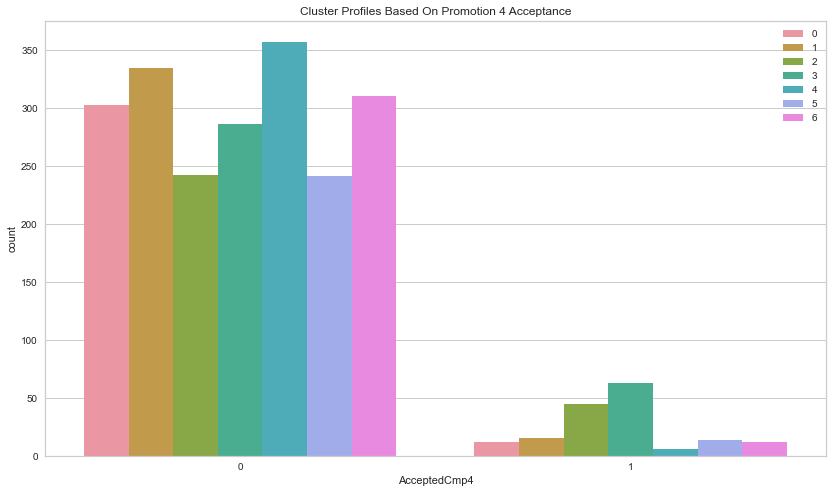

In [50]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp4"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 4 Acceptance")
plt.legend()
plt.show()

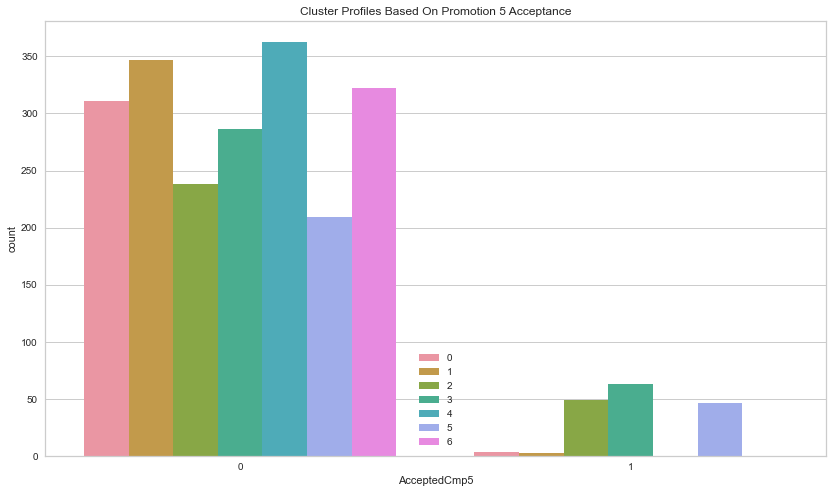

In [51]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp5"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 5 Acceptance")
plt.legend()
plt.show()

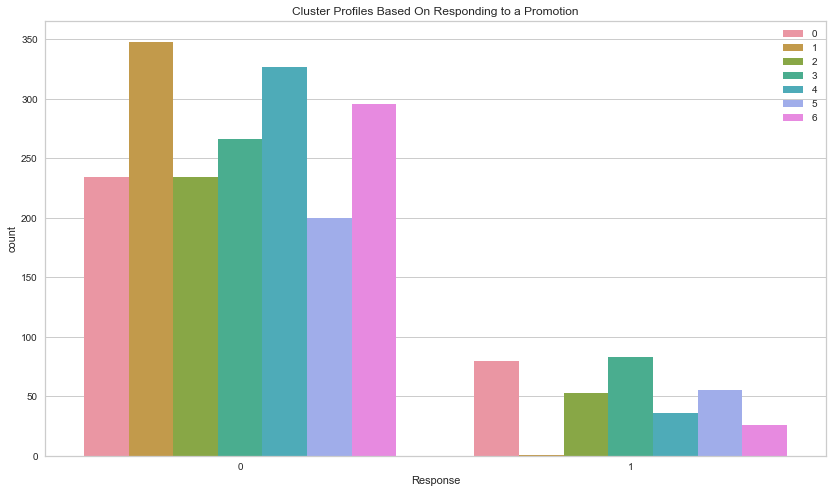

In [52]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Response"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Responding to a Promotion")
plt.legend()
plt.show()

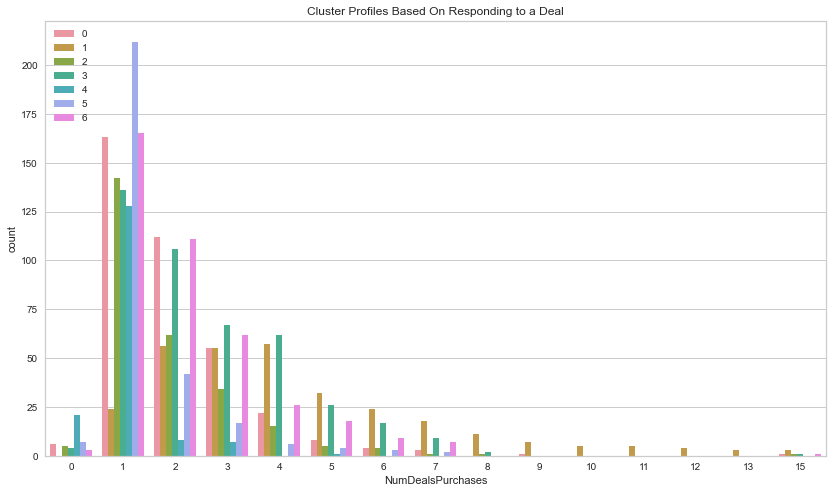

In [60]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["NumDealsPurchases"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Responding to a Deal")
plt.legend()
plt.show()


In [58]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm', 'Clusters'],
      dtype='object')

### Cluster 4 is the most responsive to promotions.  Who are these customers?
- Upper middle class
- College educated or above, with a heavy represenation of people with PhDs
- Mostly married or living together
- Are less likely to have children than average, and have fewer children
- Story: Highly educated professors and professionals -> The "Strivers"
- We don't know much about these promotions, but perhaps they are for wines, meats, and more expensive items

In [25]:
pd.set_option('display.max_columns', 50)

In [26]:
dfc4 = df[df["Clusters"]==4]

In [47]:
df.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,5590.444841,1968.802144,0.443948,0.506476,49.121036,304.067441,26.307727,167.016525,37.538633,27.074587,44.036177,2.324252,4.085306,2.662796,5.791425,5.316213,0.072800,0.074587,0.072800,0.064314,0.013399,0.149174,0.009379,51963.554712,10.753637,0.950424,0.715051,0.355516,45.197856,606.041090,0.297901,20.179991,450.564984,1.653499,2.979455
std,3246.372471,11.985494,0.538390,0.544555,28.963662,336.614830,39.781468,225.743829,54.637617,41.286043,52.174700,1.932345,2.779240,2.923542,3.251149,2.427144,0.259867,0.262782,0.259867,0.245367,0.115001,0.356339,0.096412,21410.672116,0.500189,0.751970,0.451491,0.478776,11.985494,602.274089,0.678503,7.294595,202.166032,2.173316,2.094191
min,0.000000,1893.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,7.456455,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,97.000000,0.009276,0.000000
25%,2827.500000,1959.000000,0.000000,0.000000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35533.500000,10.478259,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000,14.000000,277.500000,0.201684,1.000000
50%,5455.000000,1970.000000,0.000000,0.000000,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51381.500000,10.847053,1.000000,1.000000,0.000000,44.000000,396.000000,0.000000,19.000000,452.000000,0.865629,3.000000
75%,8423.500000,1977.000000,1.000000,1.000000,74.000000,504.500000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68277.500000,11.131350,1.000000,1.000000,1.000000,55.000000,1046.000000,0.000000,25.000000,626.000000,2.270569,5.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162397.000000,11.997805,3.000000,1.000000,1.000000,121.000000,2525.000000,4.000000,46.000000,796.000000,19.788991,6.000000


In [27]:
dfc4.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.0
mean,5193.327273,1970.739394,0.036364,0.109091,49.581818,954.690909,53.369697,503.539394,72.654545,61.084848,70.151515,1.030303,5.381818,6.115152,8.387879,3.109091,0.193939,0.412121,0.739394,0.503030,0.127273,0.551515,0.006061,80855.342424,11.292677,0.145455,0.133333,0.381818,43.260606,1715.490909,1.975758,24.024242,447.472727,4.945747,4.0
std,3079.962959,13.891960,0.187763,0.331629,29.179443,285.455746,48.108645,250.866073,54.301401,50.230858,58.669247,0.666482,2.016616,2.306951,2.701824,1.870888,0.396586,0.493715,0.440302,0.501513,0.334293,0.498853,0.077850,9764.744867,0.127411,0.386582,0.340969,0.487311,13.891960,369.016518,1.017838,4.554483,188.860723,3.206240,0.0
min,146.000000,1941.000000,0.000000,0.000000,1.000000,152.000000,0.000000,48.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48192.000000,10.782969,0.000000,0.000000,0.000000,19.000000,523.000000,0.000000,13.000000,103.000000,0.740691,4.0
25%,2611.000000,1959.000000,0.000000,0.000000,23.000000,778.000000,21.000000,309.000000,32.000000,25.000000,27.000000,1.000000,4.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75261.000000,11.228731,0.000000,0.000000,0.000000,32.000000,1493.000000,1.000000,21.000000,285.000000,2.794872,4.0
50%,4789.000000,1973.000000,0.000000,0.000000,54.000000,968.000000,33.000000,480.000000,59.000000,44.000000,48.000000,1.000000,5.000000,6.000000,8.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,82017.000000,11.314694,0.000000,0.000000,0.000000,41.000000,1722.000000,2.000000,24.000000,457.000000,3.914000,4.0
75%,7789.000000,1982.000000,0.000000,0.000000,75.000000,1142.000000,74.000000,716.000000,104.000000,91.000000,101.000000,1.000000,7.000000,8.000000,11.000000,4.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,87679.000000,11.381449,0.000000,0.000000,1.000000,55.000000,1957.000000,3.000000,27.000000,592.000000,5.939655,4.0
max,11088.000000,1995.000000,1.000000,2.000000,98.000000,1493.000000,185.000000,974.000000,232.000000,194.000000,241.000000,5.000000,11.000000,11.000000,13.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102692.000000,11.539499,2.000000,1.000000,1.000000,73.000000,2525.000000,4.000000,37.000000,794.000000,19.788991,4.0


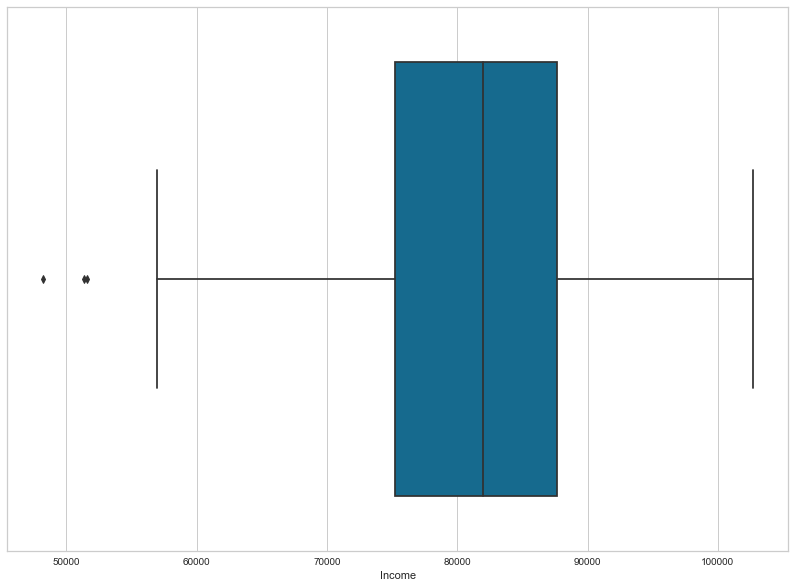

In [28]:
plt.figure(figsize=(14,10))

ax=sns.boxplot(x = 'Income', data = dfc4)

<AxesSubplot:>

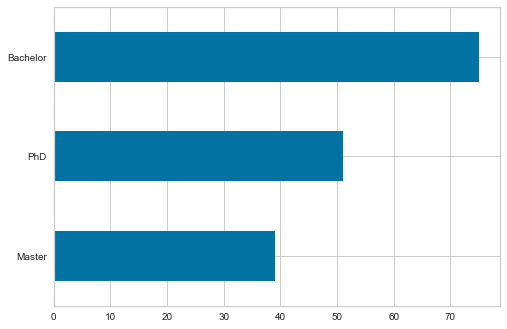

In [29]:
dfc4.Education.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

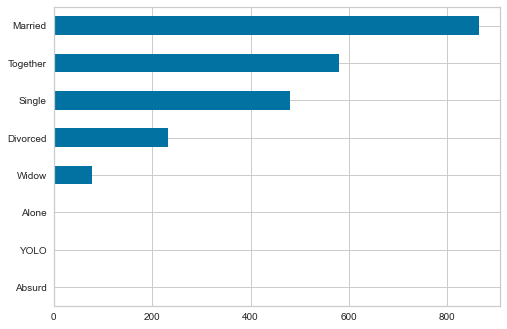

In [30]:
df.Marital_Status.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

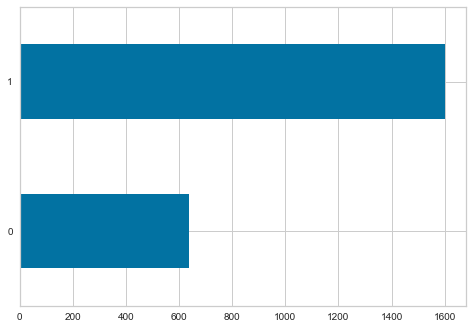

In [49]:
df.HasChildren.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

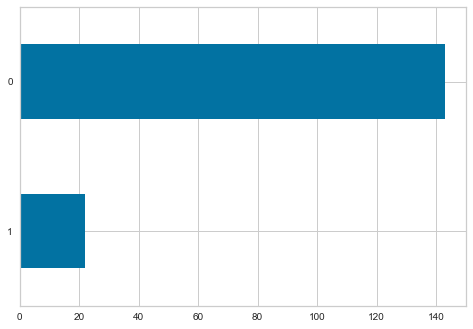

In [51]:
dfc4.HasChildren.value_counts().sort_values().plot(kind = 'barh')

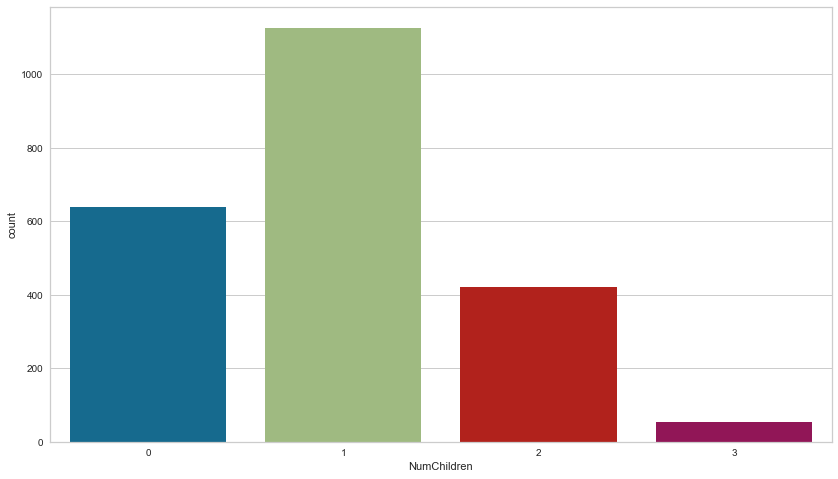

In [54]:
plt.figure(figsize=(14, 8))
sns.countplot(x='NumChildren', data=df)
plt.show()

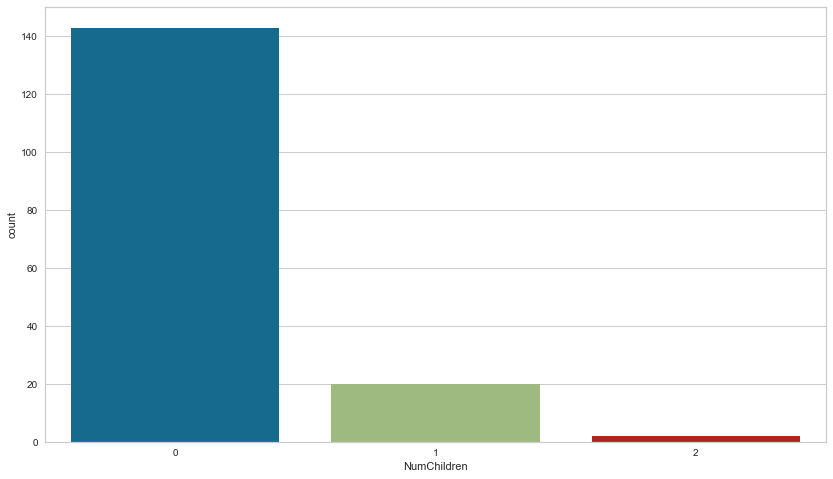

In [55]:
plt.figure(figsize=(14, 8))
sns.countplot(x='NumChildren', data=dfc4)
plt.show()

#### Mostly high income customers (mean income of 80855 compared to 51963.554712 overall average)

In [31]:
df.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,5590.444841,1968.802144,0.443948,0.506476,49.121036,304.067441,26.307727,167.016525,37.538633,27.074587,44.036177,2.324252,4.085306,2.662796,5.791425,5.316213,0.072800,0.074587,0.072800,0.064314,0.013399,0.149174,0.009379,51963.554712,10.753637,0.950424,0.715051,0.355516,45.197856,606.041090,0.297901,20.179991,450.564984,1.653499,2.979455
std,3246.372471,11.985494,0.538390,0.544555,28.963662,336.614830,39.781468,225.743829,54.637617,41.286043,52.174700,1.932345,2.779240,2.923542,3.251149,2.427144,0.259867,0.262782,0.259867,0.245367,0.115001,0.356339,0.096412,21410.672116,0.500189,0.751970,0.451491,0.478776,11.985494,602.274089,0.678503,7.294595,202.166032,2.173316,2.094191
min,0.000000,1893.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,7.456455,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,97.000000,0.009276,0.000000
25%,2827.500000,1959.000000,0.000000,0.000000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35533.500000,10.478259,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000,14.000000,277.500000,0.201684,1.000000
50%,5455.000000,1970.000000,0.000000,0.000000,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51381.500000,10.847053,1.000000,1.000000,0.000000,44.000000,396.000000,0.000000,19.000000,452.000000,0.865629,3.000000
75%,8423.500000,1977.000000,1.000000,1.000000,74.000000,504.500000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68277.500000,11.131350,1.000000,1.000000,1.000000,55.000000,1046.000000,0.000000,25.000000,626.000000,2.270569,5.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162397.000000,11.997805,3.000000,1.000000,1.000000,121.000000,2525.000000,4.000000,46.000000,796.000000,19.788991,6.000000


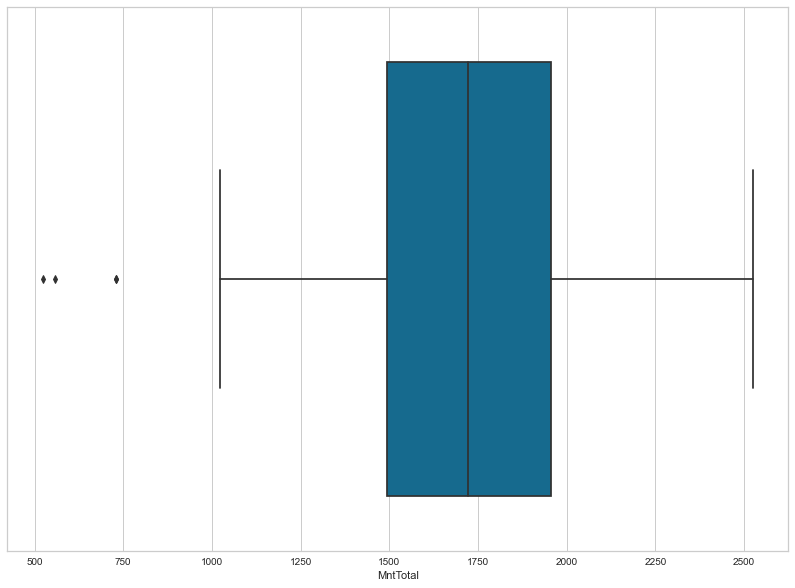

In [32]:
plt.figure(figsize=(14,10))

ax=sns.boxplot(x = 'MntTotal', data = dfc4)

#### These customers spend much more on average! (compare with the graph below)

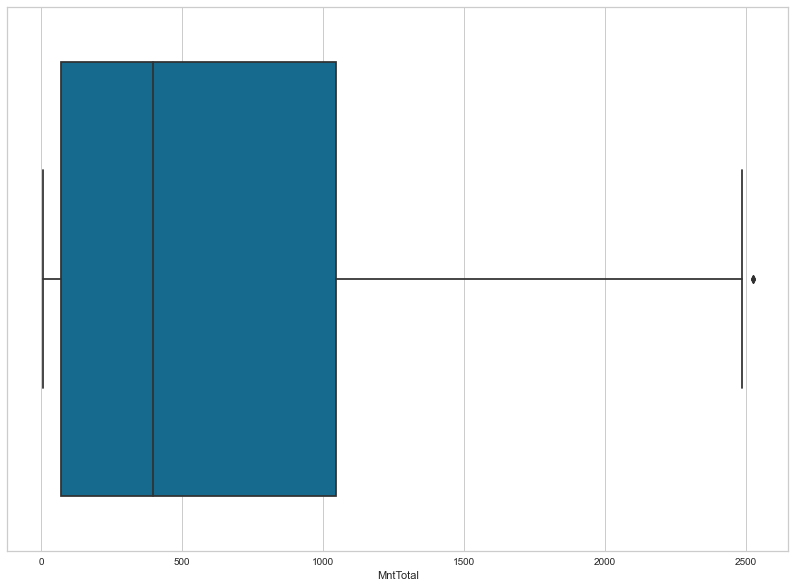

In [33]:
plt.figure(figsize=(14,10))

ax=sns.boxplot(x = 'MntTotal', data = df)

## LOOK FOR TOTAL SPENDING BY CLUSTER.  WHICH ONES BRING THE MOST REVENUE?  (TOTAL AMOUNT SPENT * CUSTOMER GROUP SIZE)

In [53]:
cluster_mnt_totals = [[]]*n_clusters

In [54]:
for i in range(n_clusters):
    cluster_i=df[df["Clusters"]==i]
    cluster_mnt_totals[i] = cluster_i.MntTotal.mean()*len(cluster_i)

In [55]:
cluster_mnt_totals 

[105807.0, 81653.0, 300315.0, 435890.0, 34036.0, 351015.0, 48210.0]

In [56]:
columns = ['cluster'+str(i) for i in range(n_clusters)]
columns

['cluster0',
 'cluster1',
 'cluster2',
 'cluster3',
 'cluster4',
 'cluster5',
 'cluster6']

In [57]:
df_cluster_mnt_totals = pd.DataFrame([cluster_mnt_totals], columns = ['cluster'+str(i) for i in range(n_clusters)])

In [58]:
df.sort_values('c', ascending=False)[['a','b']].plot.bar()

KeyError: 'c'

In [59]:
df_cluster_mnt_totals=df_cluster_mnt_totals.T.reset_index().rename({0:'TotalAmountSpent'},axis=1)

<AxesSubplot:>

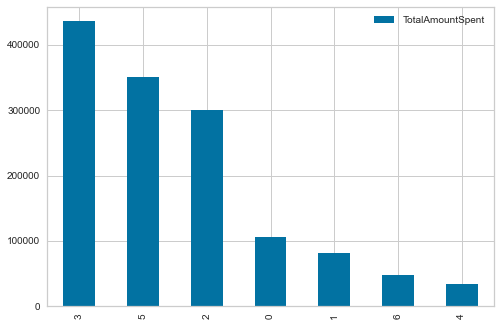

In [60]:
df_cluster_mnt_totals.sort_values('TotalAmountSpent', ascending=False).plot.bar()

<AxesSubplot:>

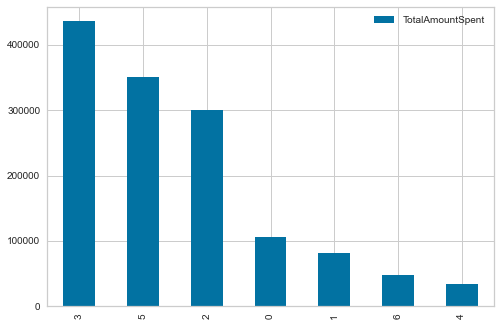

In [61]:
df_cluster_mnt_totals.sort_values('TotalAmountSpent', ascending=False).plot.bar()

In [ ]:
df_cluster_mnt_totals = df_cluster_mnt_totals.pivot('day','group','amount').reset_index()

In [88]:
df.sort_values(df_cluster_mnt_totals.columns, ascending=False)[['cluster1','cluster2']].plot.bar()

KeyError: Index(['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5',
       'cluster6'],
      dtype='object')

<AxesSubplot:>

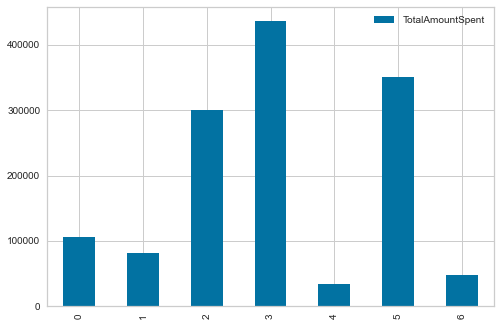

In [62]:
df_cluster_mnt_totals.plot.bar()

In [ ]:
# Try this
# plt.figure(figsize=(14, 8))
# sns.countplot(x='NumChildren', data=df_cluster_mnt_totals, order=df_cluster_mnt_totals['NumChildren'].value_counts().index)
# plt.show()

In [84]:
df_cluster_mnt_totals.columns

Index(['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5',
       'cluster6'],
      dtype='object')

<BarContainer object of 1 artists>

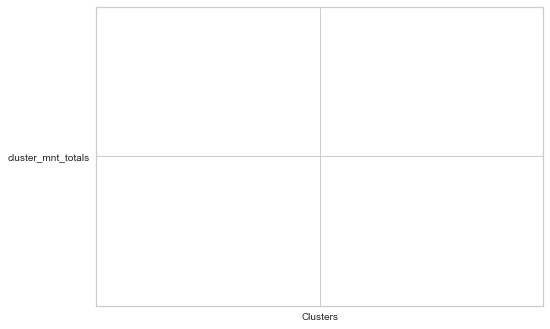

In [86]:
df_sorted = df_cluster_mnt_totals.sort_values(['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5',
       'cluster6'])
plt.bar('Clusters', 'cluster_mnt_totals', data=df_sorted, color='orange')


In [82]:
df_sorted.columns

NameError: name 'df_sorted' is not defined

In [80]:
df_cluster_mnt_totals.sorted_values().plot.bar()

AttributeError: 'DataFrame' object has no attribute 'sorted_values'

### Cluster 5 brings in even more revenue, yet is even less responsive to promotions.  Who are these customers? 
- Also wealthy, but less than Cluster 5 customers (1 vs 1.5 std devs to the right)
- Mostly college educated, with many people with graduate degrees and some HS graduates
- Are slightly less likely to have children than average, but more so than the 'Strivers'; have fewer children than average
- The 'Professionals'

In [40]:
dfc5 = df[df["Clusters"]==5]

In [41]:
dfc5.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.0
mean,5664.443686,1968.344710,0.027304,0.194539,53.686007,490.105802,88.658703,438.791809,130.412969,83.262799,89.812287,1.443686,5.232082,5.580205,8.358362,3.071672,0.030717,0.020478,0.078498,0.092150,0.003413,0.204778,0.006826,72425.513652,11.176107,0.221843,0.218430,0.402730,45.655290,1321.044369,0.225256,23.686007,518.095563,3.224912,5.0
std,3337.839618,13.264716,0.163246,0.405067,28.458881,232.386677,50.270429,228.654135,64.890029,52.149113,61.735258,1.053892,2.185113,2.328623,2.800056,1.908430,0.172844,0.141870,0.269414,0.289733,0.058421,0.404230,0.082478,11230.149094,0.177710,0.424346,0.413888,0.491286,13.264716,365.338642,0.486577,5.231331,194.658159,2.350109,0.0
min,0.000000,1899.000000,0.000000,0.000000,0.000000,33.000000,0.000000,64.000000,0.000000,0.000000,9.000000,0.000000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31907.000000,10.370612,0.000000,0.000000,0.000000,19.000000,449.000000,0.000000,12.000000,98.000000,0.712000,5.0
25%,2712.000000,1958.000000,0.000000,0.000000,30.000000,324.000000,50.000000,259.000000,77.000000,40.000000,40.000000,1.000000,4.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66825.000000,11.109848,0.000000,0.000000,0.000000,36.000000,1049.000000,0.000000,20.000000,361.000000,1.951977,5.0
50%,5602.000000,1970.000000,0.000000,0.000000,57.000000,463.000000,83.000000,405.000000,130.000000,76.000000,79.000000,1.000000,5.000000,5.000000,8.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72905.000000,11.196926,0.000000,0.000000,0.000000,44.000000,1319.000000,0.000000,23.000000,550.000000,2.526475,5.0
75%,8690.000000,1978.000000,0.000000,0.000000,77.000000,635.000000,129.000000,573.000000,181.000000,125.000000,126.000000,2.000000,6.000000,7.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80317.000000,11.293749,0.000000,0.000000,1.000000,56.000000,1565.000000,0.000000,27.000000,684.000000,3.393130,5.0
max,11112.000000,1995.000000,1.000000,2.000000,99.000000,1218.000000,199.000000,984.000000,259.000000,198.000000,249.000000,7.000000,11.000000,11.000000,13.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,105471.000000,11.566201,2.000000,1.000000,1.000000,115.000000,2352.000000,2.000000,39.000000,793.000000,15.682692,5.0


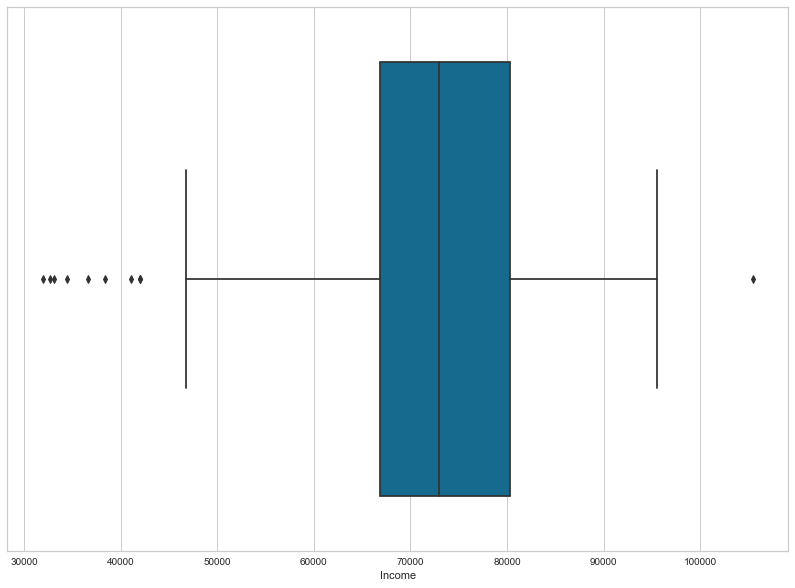

In [42]:
plt.figure(figsize=(14,10))

ax=sns.boxplot(x = 'Income', data = dfc5) #72425.513652, higher than average income of 51963.554712

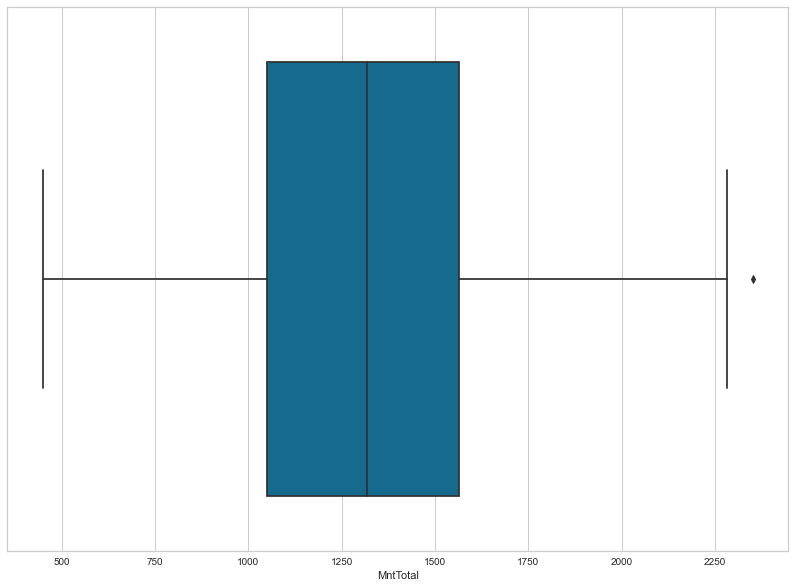

In [43]:
plt.figure(figsize=(14,10))

ax=sns.boxplot(x = 'MntTotal', data = dfc5)

<AxesSubplot:>

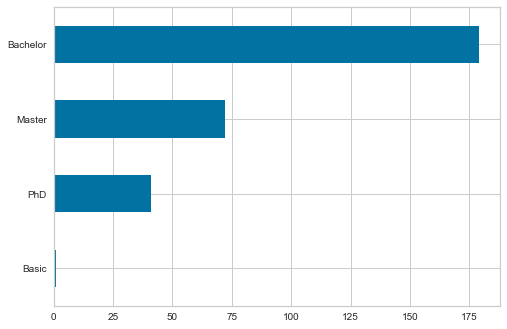

In [44]:
dfc5.Education.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

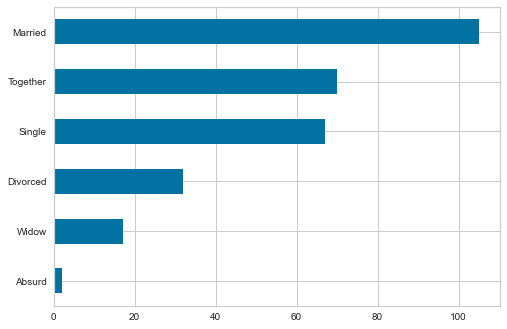

In [48]:
dfc5.Marital_Status.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

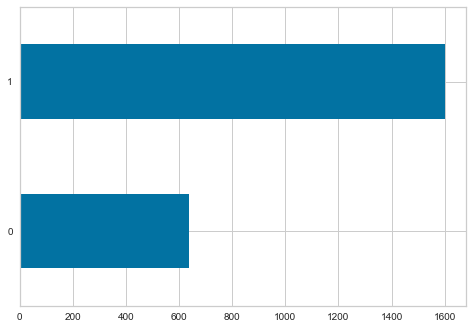

In [53]:
df.HasChildren.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

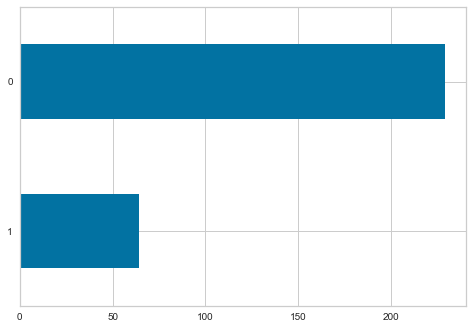

In [52]:
dfc5.HasChildren.value_counts().sort_values().plot(kind = 'barh')

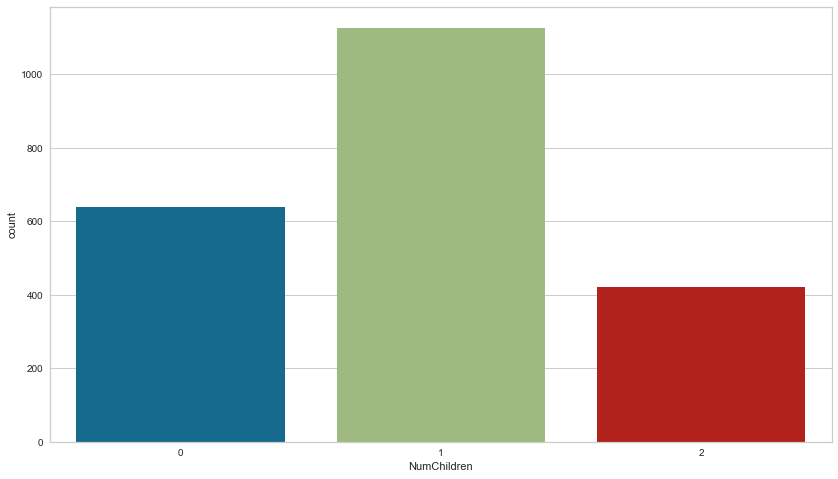

In [77]:
plt.figure(figsize=(14, 8))
sns.countplot(x='NumChildren', data=df,order=dfc5['NumChildren'].value_counts().index)
plt.show()

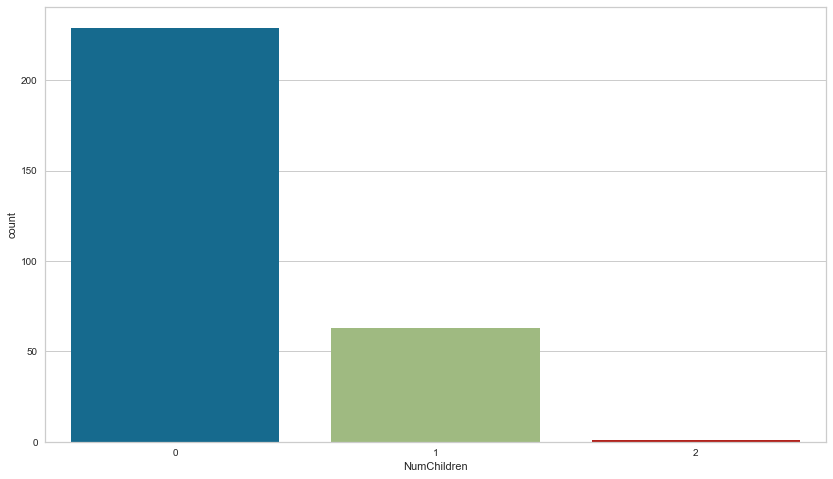

In [57]:
plt.figure(figsize=(14, 8))
sns.countplot(x='NumChildren', data=dfc5)
plt.show()

In [45]:
#### Cluster 5 is larger than Cluster 1, brings in about just as much revenue as Cluster 1, yet is less responsive to promotions.  Business recommendation: Look for ways to target Cluster 5 members! 

In [46]:
### Apart from average income, what else can we learn about this cluster? Need to figure out how to 'undo' the cat conversion/read from categories dictionary to make meaningful graphs

### Cluster 1 are the repeated deal hunters.  Who are they?
- Higher than average income (.5 standard dev)
- Highly educated (lots of PhDs)
- Overwhelmingly have children
- The 'Familied Philosophers'

In [61]:
dfc1 = df[df["Clusters"]==1]

In [66]:
dfc1.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.0
mean,5283.759868,1964.700658,0.273026,0.930921,53.398026,608.526316,26.605263,193.608553,32.677632,28.085526,68.309211,4.430921,6.940789,4.046053,8.726974,6.118421,0.078947,0.138158,0.023026,0.029605,0.016447,0.151316,0.006579,60716.968750,10.991584,1.203947,0.944079,0.368421,49.299342,957.812500,0.286184,30.263158,619.000000,1.605415,1.0
std,3225.642802,9.868736,0.460803,0.428172,26.874899,282.641161,28.750815,169.092398,35.249437,32.738073,53.768878,2.794708,2.572342,2.946921,2.672645,1.757339,0.270101,0.345635,0.150234,0.169775,0.127398,0.358947,0.080977,11730.693943,0.250703,0.566837,0.230148,0.483172,9.868736,342.822214,0.557286,4.891883,118.672025,0.674779,0.0
min,17.000000,1943.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2447.000000,7.803027,0.000000,0.000000,0.000000,22.000000,416.000000,0.000000,17.000000,253.000000,0.539559,1.0
25%,2514.500000,1956.000000,0.000000,1.000000,33.000000,385.750000,7.000000,99.750000,9.500000,6.000000,27.000000,2.000000,5.000000,2.000000,7.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54325.250000,10.902762,1.000000,1.000000,0.000000,43.000000,684.000000,0.000000,27.000000,543.500000,1.136904,1.0
50%,5214.000000,1965.000000,0.000000,1.000000,55.000000,561.500000,16.000000,156.000000,20.000000,15.500000,51.500000,4.000000,7.000000,3.000000,9.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60046.500000,11.002891,1.000000,1.000000,0.000000,49.000000,928.500000,0.000000,30.000000,630.500000,1.513943,1.0
75%,8219.000000,1971.000000,1.000000,1.000000,76.000000,791.500000,41.250000,238.250000,46.000000,40.250000,99.000000,6.000000,9.000000,5.000000,11.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66498.250000,11.104946,1.000000,1.000000,1.000000,58.000000,1163.500000,0.000000,33.250000,721.250000,1.883102,1.0
max,10992.000000,1992.000000,2.000000,2.000000,99.000000,1349.000000,159.000000,1725.000000,223.000000,151.000000,247.000000,15.000000,11.000000,28.000000,13.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,160803.000000,11.987942,3.000000,1.000000,1.000000,71.000000,2092.000000,3.000000,46.000000,795.000000,4.971787,1.0


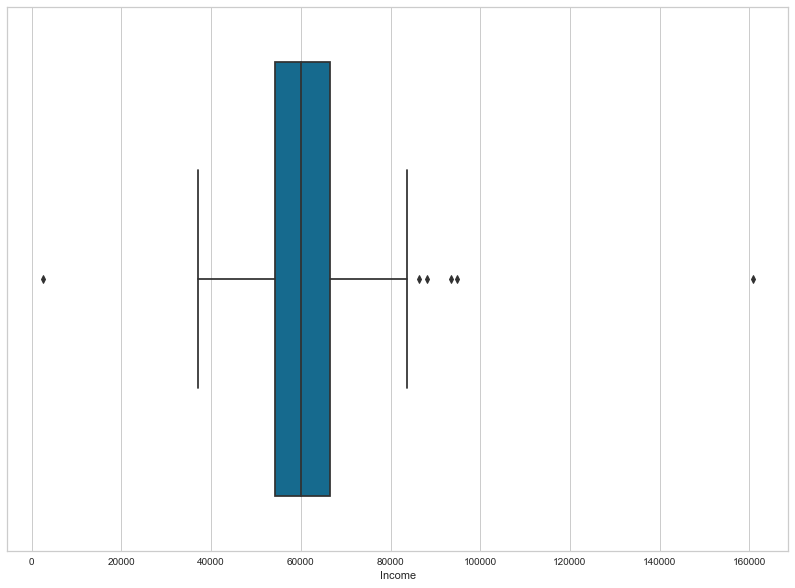

In [64]:
plt.figure(figsize=(14,10))

ax=sns.boxplot(x = 'Income', data = dfc1) #60716.96875, higher than average income of 51963.554712, about half a standard deviation to the right

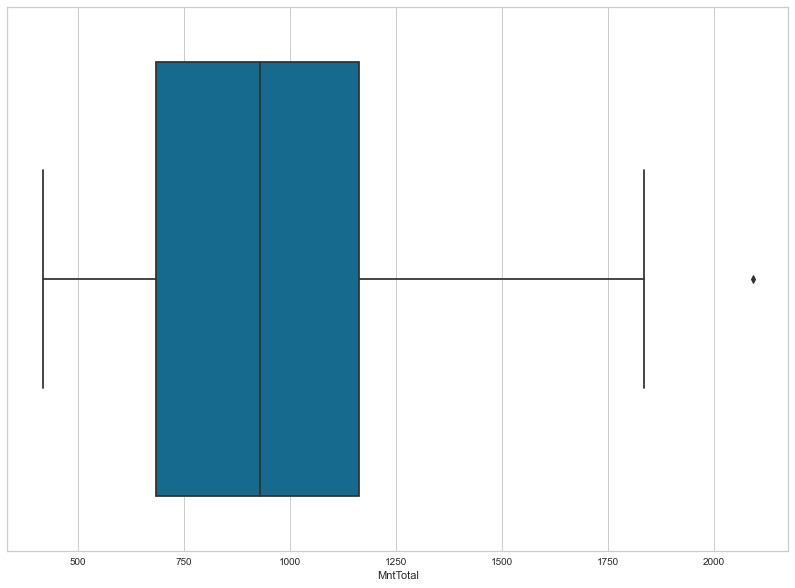

In [67]:
plt.figure(figsize=(14,10))

ax=sns.boxplot(x = 'MntTotal', data = dfc1)

<AxesSubplot:>

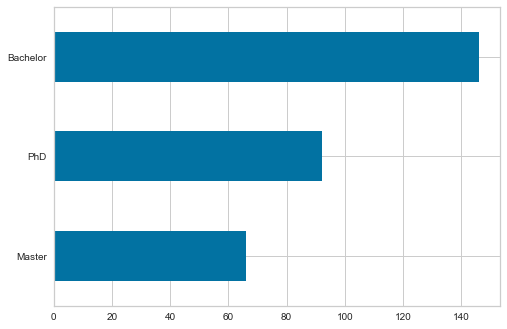

In [68]:
dfc1.Education.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

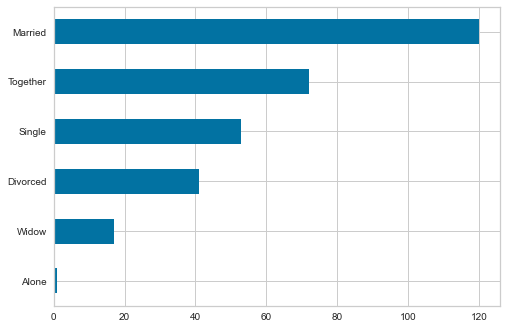

In [69]:
dfc1.Marital_Status.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

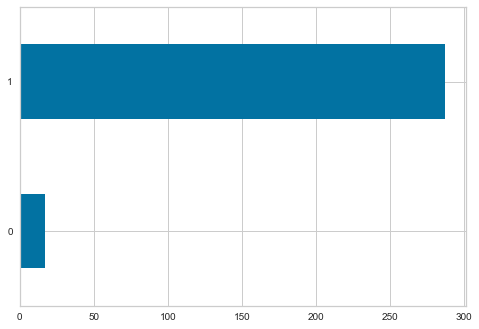

In [70]:
dfc1.HasChildren.value_counts().sort_values().plot(kind = 'barh')

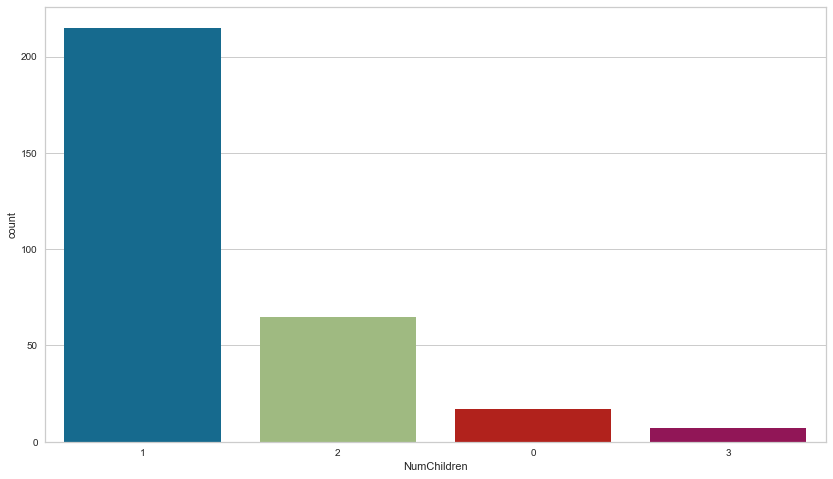

In [76]:
plt.figure(figsize=(14, 8))
sns.countplot(x='NumChildren', data=dfc1, order=dfc1['NumChildren'].value_counts().index)
plt.show()

### Trying to create a script to run analyses through the clusters

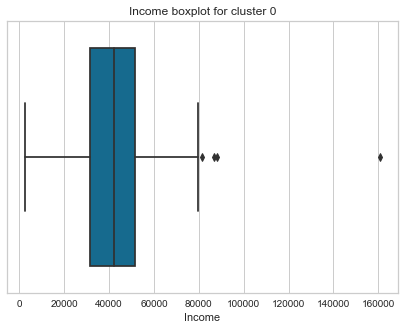

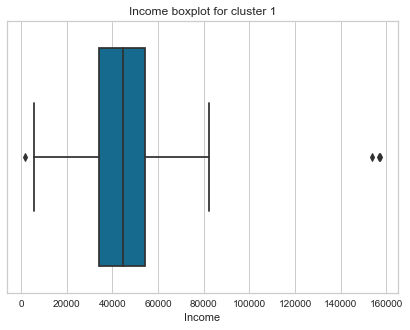

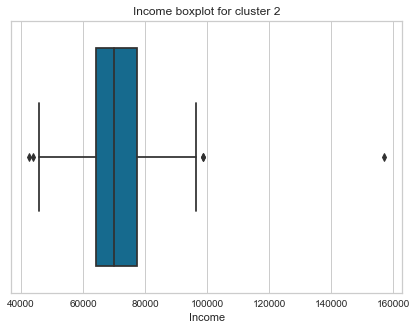

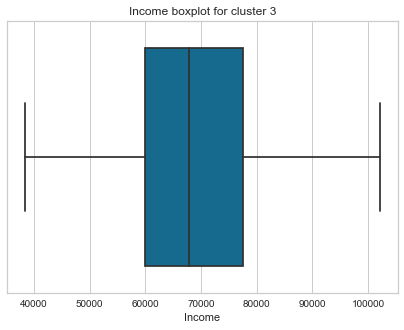

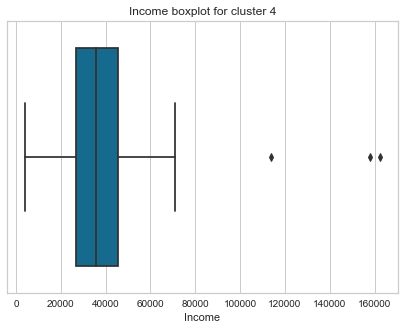

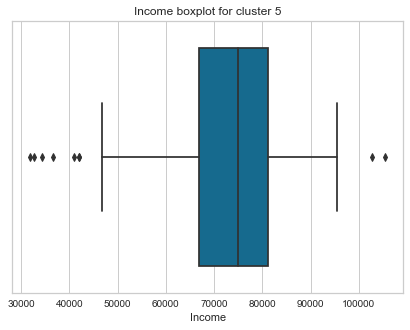

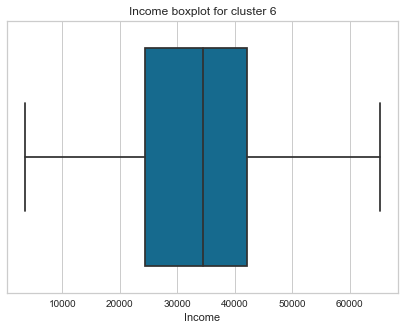

In [69]:
dfc = [[]]*n_clusters
for i in range(n_clusters):
    dfc[i] = df[df["Clusters"]==i]
    plt.figure(figsize=(7,5))
    plot=sns.boxplot(x = 'Income', data = dfc[i])
    plot.set_title(f'Income boxplot for cluster {i}')

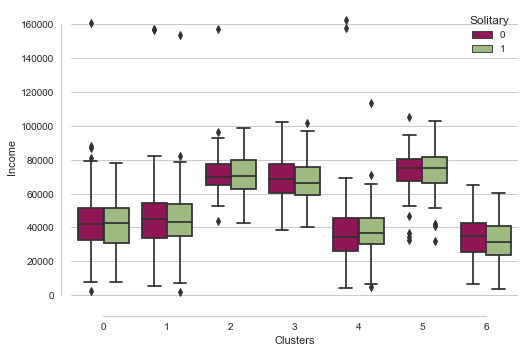

In [83]:
sns.boxplot(x="Clusters", y="Income",
            hue="Solitary", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

In [ ]:
###  Customers in Clusters 2, 3, 5 who  have higher income and less on average!

### Grouped Analyses

In [142]:
dfc = [[]]*n_clusters
for i in range(n_clusters):
    dfc[i] = df[df["Clusters"]==i]

In [143]:
#palette=sns.color_palette("rocket")
palette=sns.color_palette("Set2")

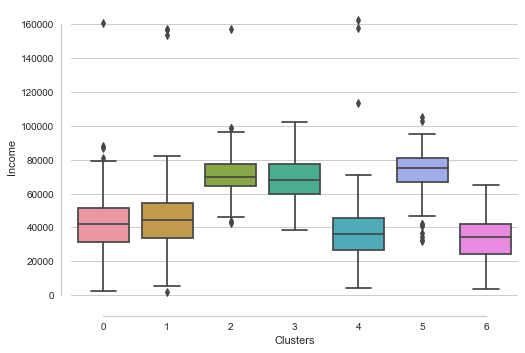

In [144]:
sns.boxplot(x="Clusters", y="Income",
            data=df)
sns.despine(offset=10, trim=True)

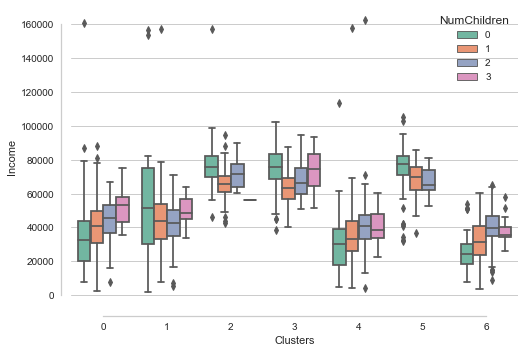

In [145]:
sns.boxplot(x="Clusters", y="Income",
            hue="NumChildren", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)

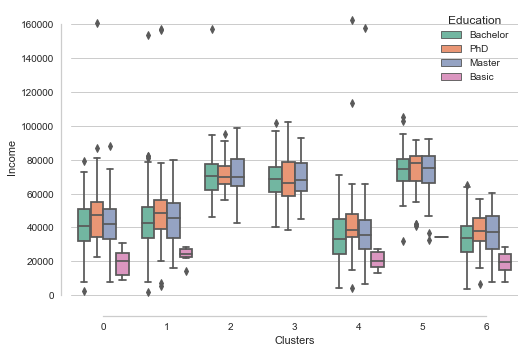

In [146]:
sns.boxplot(x="Clusters", y="Income",
            hue="Education", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)

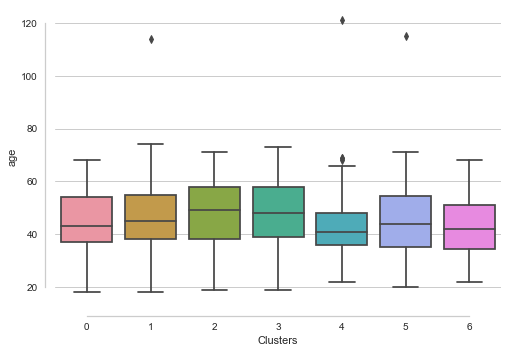

In [136]:
sns.boxplot(x="Clusters", y="age",
            data=df)
sns.despine(offset=10, trim=True)

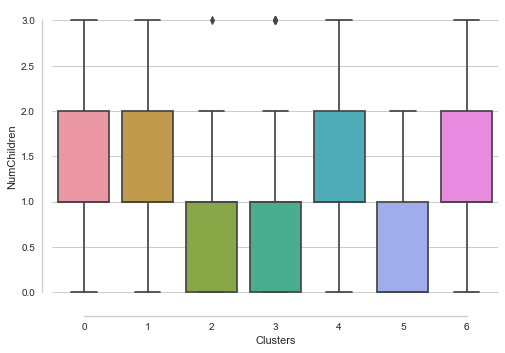

In [139]:
sns.boxplot(x="Clusters", y="NumChildren",
            data=df)
sns.despine(offset=10, trim=True)

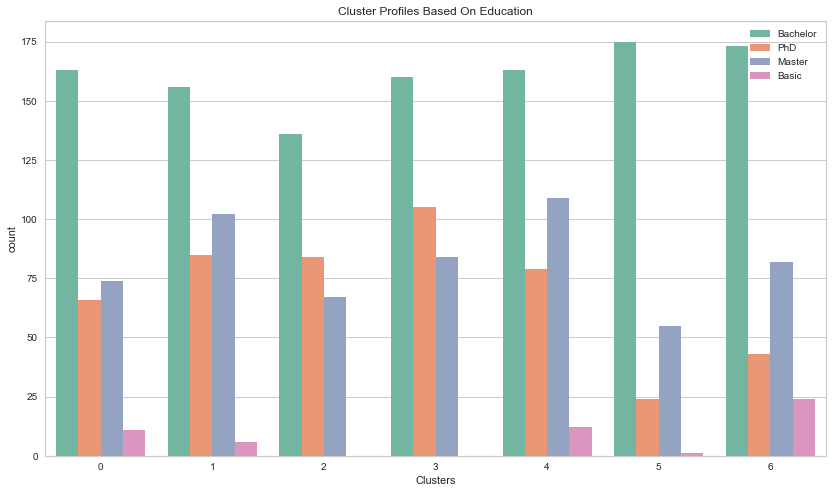

In [137]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Clusters"],hue=df["Education"], palette = palette)

plot.set_title("Cluster Profiles Based On Education")
plt.legend()
plt.show()

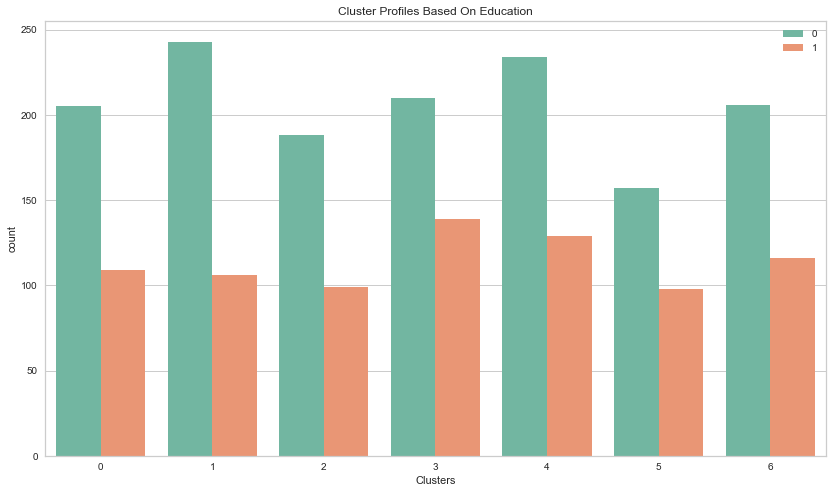

In [138]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Clusters"],hue=df["Solitary"], palette = palette)

plot.set_title("Cluster Profiles Based On Education")
plt.legend()
plt.show()

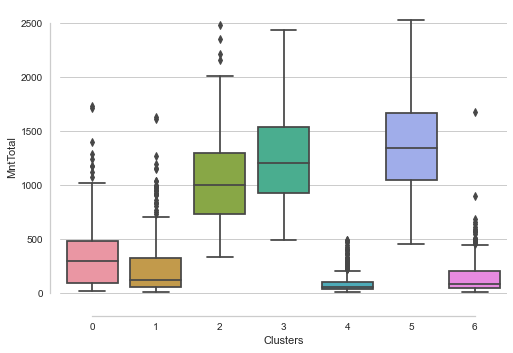

In [88]:
sns.boxplot(x="Clusters", y="MntTotal",
            data=df)
sns.despine(offset=10, trim=True)

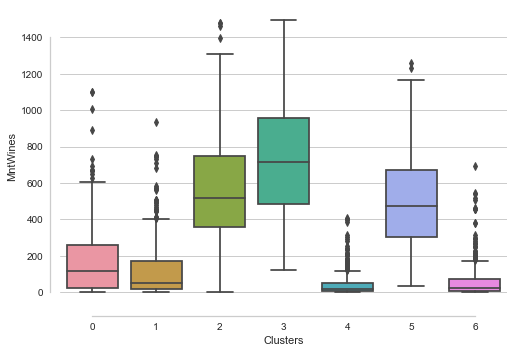

In [101]:
sns.boxplot(x="Clusters", y="MntWines",
            data=df)
sns.despine(offset=10, trim=True)

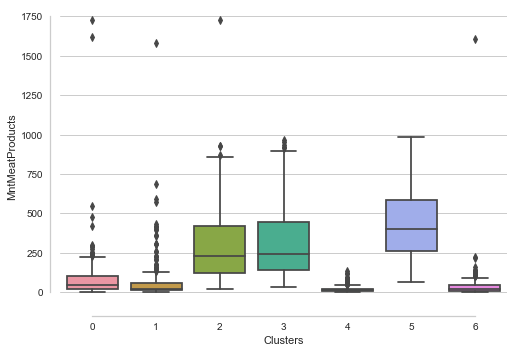

In [102]:
sns.boxplot(x="Clusters", y="MntMeatProducts",
            data=df)
sns.despine(offset=10, trim=True)

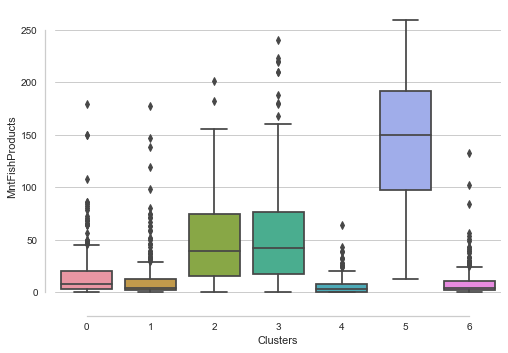

In [103]:
sns.boxplot(x="Clusters", y="MntFishProducts",
            data=df)
sns.despine(offset=10, trim=True)



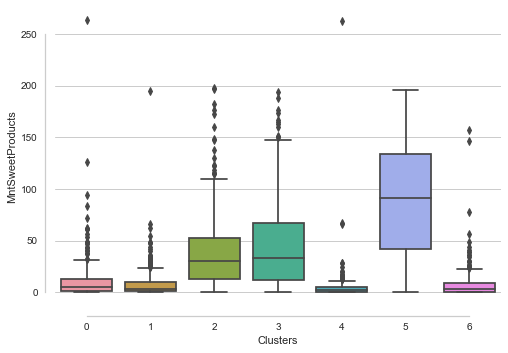

In [104]:
sns.boxplot(x="Clusters", y="MntSweetProducts",
            data=df)
sns.despine(offset=10, trim=True)


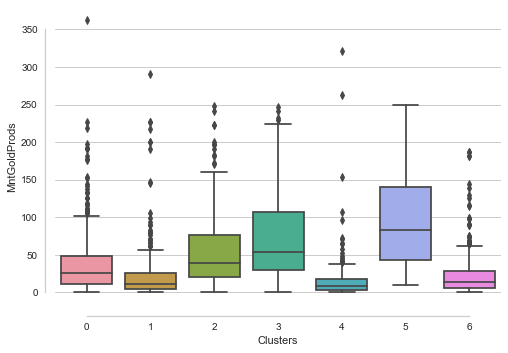

In [105]:
sns.boxplot(x="Clusters", y="MntGoldProds",
            data=df)
sns.despine(offset=10, trim=True)

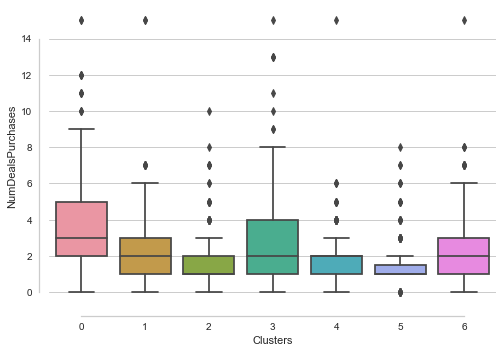

In [106]:
sns.boxplot(x="Clusters", y="NumDealsPurchases",
            data=df)
sns.despine(offset=10, trim=True)

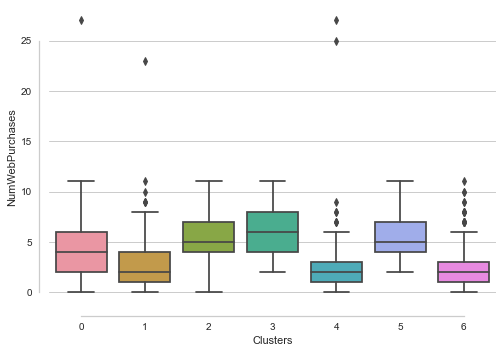

In [108]:
sns.boxplot(x="Clusters", y="NumWebPurchases",
            data=df)
sns.despine(offset=10, trim=True)

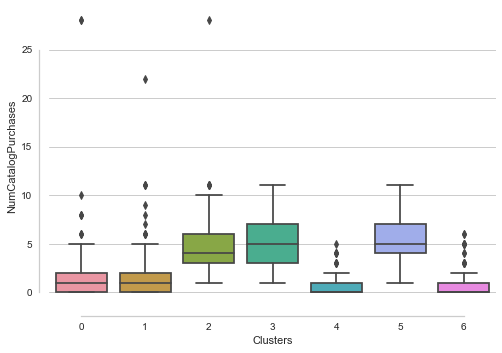

In [109]:
sns.boxplot(x="Clusters", y="NumCatalogPurchases",
            data=df)
sns.despine(offset=10, trim=True)

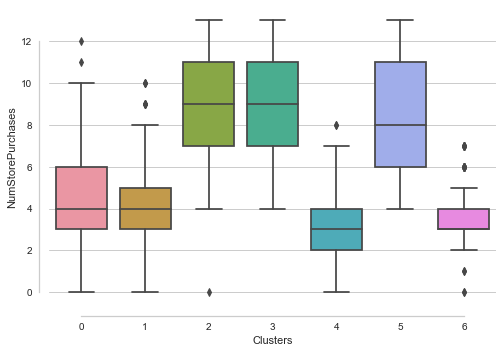

In [110]:
sns.boxplot(x="Clusters", y="NumStorePurchases",
            data=df)
sns.despine(offset=10, trim=True)

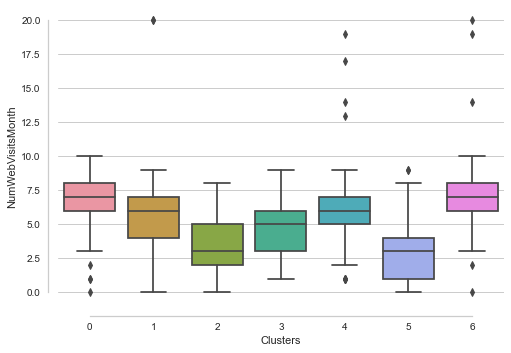

In [111]:
sns.boxplot(x="Clusters", y="NumWebVisitsMonth",
            data=df)
sns.despine(offset=10, trim=True)

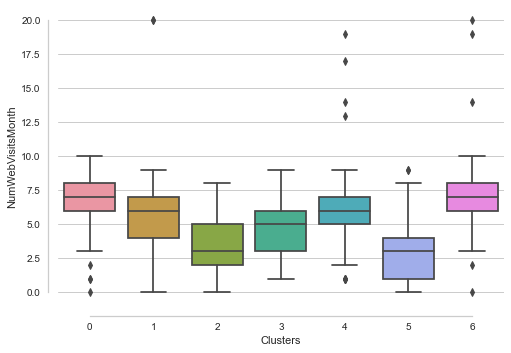

In [111]:
sns.boxplot(x="Clusters", y="NumWebVisitsMonth",
            data=df)
sns.despine(offset=10, trim=True)

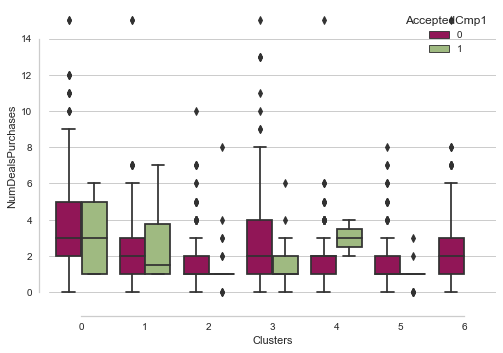

In [112]:
sns.boxplot(x="Clusters", y="NumDealsPurchases",
            hue="AcceptedCmp1", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

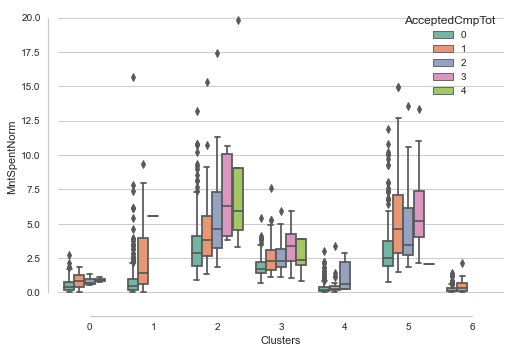

In [125]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

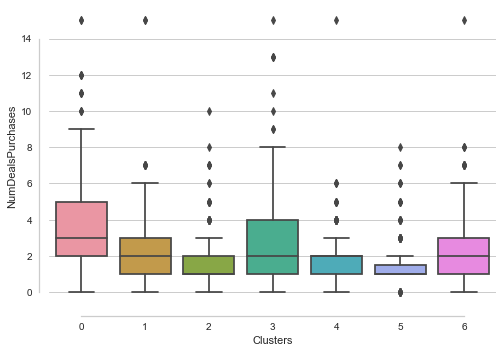

In [127]:
sns.boxplot(x="Clusters", y="NumDealsPurchases",
            #hue="NumDealsPurchases", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

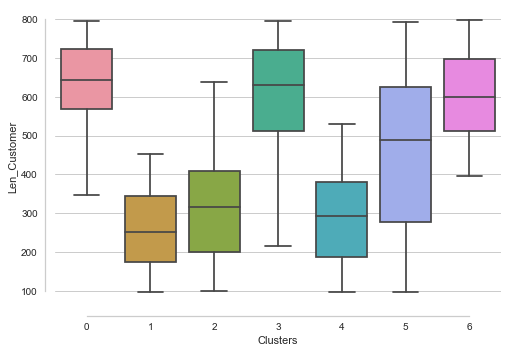

In [128]:
sns.boxplot(x="Clusters", y="Len_Customer",
            #hue="AcceptedCmpTot", palette=["m", "g","y","b","p"],
            data=df)
sns.despine(offset=10, trim=True)

In [107]:
['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm', 'Clusters']

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Response',
 'Complain',
 'Country',
 'Income',
 'LogIncome',
 'NumChildren',
 'HasChildren',
 'Solitary',
 'age',
 'MntTotal',
 'AcceptedCmpTot',
 'NumTotalPurchases',
 'Len_Customer',
 'MntSpentNorm',
 'Clusters']

###  Customers in Clusters 2, 3, 5 who  have children spend less on average!

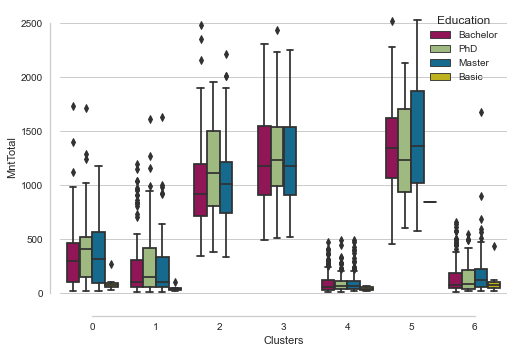

In [81]:
sns.boxplot(x="Clusters", y="MntTotal",
            hue="Education", palette=["m", "g","b","y"],
            data=df)
sns.despine(offset=10, trim=True)

#### Recommend A/B testing on clusters